# Make tree for East Woods
### v1, 2018-04-11<br>ahipp@mortonarb.org
This is our first round of East Woods data analysis, and the tree that we produce today will not be the final version. But we can edit from here, and we'll use this notebook to perform and document analyses.

Steps:
1. Read species list and tree files
2. Clean species names
3. Prune tree
4. Visualize tree, make sure things are working well
5. Quantify what species are missing

We'll stop at ths point for now; in the next round, we at least two options: 
* use the `makeMat` function from the [morton project](https://github.com/andrew-hipp/morton/blob/master/R/makeMat.R)... this is essentially a Phylomatic approach with a bit more control;
* add in taxa using sequence data

We'll figure this out later.

## Read data 
First, let's make a working directory and move into it.

In [55]:
if(!"WORKING" %in% dir('../')) dir.create('../WORKING')
setwd('../WORKING')
getwd()

[1] "/home/andrew/Documents/code/EastWoods-2018/WORKING"

Now let's get our data. I've put what we want into a folder called 'DATA' that is at the same level as 'WORKING'. Our data are in three spreadsheets, one each for shrubs, trees and herbs. We'll deal with that later.

In [56]:
spp.list <- lapply(dir('../DATA', patt = 'spp.', full = T), read.csv, as.is = T)
names(spp.list) <- gsub('.csv', '', dir('../DATA', patt = 'spp.'))
temp <- sapply(spp.list, dim)
temp
message(paste('Total spp entries:', sum(temp[1,])))

spp.herb.2007,spp.shrub.2007,spp.trees.2007
2780,862,4782
8,10,8


Total spp entries: 8424


And let's get our tree. We'll use the `ape` package for most tree manipulations and visualization.

In [57]:
library(ape)

if(!exists('tr.zanne')) tr.zanne <- read.tree('../DATA/phylo.zanne.tre') # check first, b/c it's a slow file to load
tr.zanne


Phylogenetic tree with 31749 tips and 31748 internal nodes.

Tip labels:
	Blasia_pusilla, Lunularia_cruciata, Marchantia_polymorpha, Riccia_fluitans, Reboulia_hemisphaerica, Marchantia_foliacea, ...
Node labels:
	, , , , , , ...

Rooted; includes branch lengths.

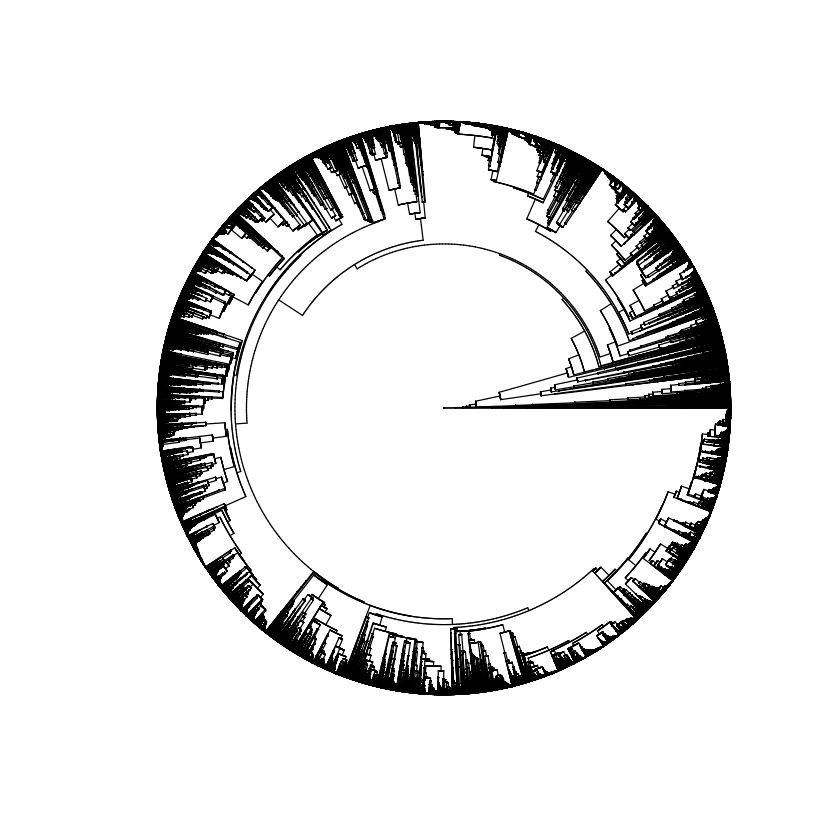

In [58]:
plot(tr.zanne, 'fan', show.tip.label = F)

## Clean species names
Let's get one list of species names, and make sure they have underlines instead of spaces between the genus and epithet. Then let's check to make sure there are no monomials or trinomials. This is going to be a _super_ conservative list, but it's a place to start.

In [59]:
spp.vect <- do.call(c, lapply(spp.list, function(x) x$species))
message(paste('Total spp entries:', length(spp.vect)))
spp.vect <- sort(unique(trimws(spp.vect)))
message(paste('Unique spp entries:', length(spp.vect)))
spp.vect <- gsub(" ", "_", spp.vect)
spp.vect <- sapply(strsplit(spp.vect, "_"), function(x) paste(x[1:2], collapse = "_"))
spp.vect <- unique(spp.vect)
message(paste('Unique binomials:', length(spp.vect)))
spp.vect <- spp.vect[-grep('NONE|NA|species', spp.vect)]
message(paste('Unique binomials, excluding indets:', length(spp.vect)))

Total spp entries: 8424
Unique spp entries: 318
Unique binomials: 316
Unique binomials, excluding indets: 250


Now you may want to clean these names further... we can get the accepted name for each using the [Taxonomic Name Resolution Service](http://tnrs.iplantcollaborative.org/index.html) from the iPlant collective. Fortunately, there's an API, which returns json data... you can parse that using the `jsonlite` package.

In [60]:
library(jsonlite)
tnrs.base <- 'http://tnrs.iplantc.org/tnrsm-svc/matchNames?retrieve=best&names='
spp.vect.tnrs <- paste(gsub("_", "%20", spp.vect), collapse = ',')
tnrs.json <- readLines(paste(tnrs.base, spp.vect.tnrs, sep = ''), warn = F)
tnrs.mat <- fromJSON(tnrs.json)$items
head(tnrs.mat)

group,acceptedName,acceptedAuthor,nameSubmitted,url,nameScientific,scientificScore,matchedFamily,matchedFamilyScore,authorAttributed,⋯,authorScore,annotation,unmatched,overall,epithet,epithetScore,acceptance,familySubmitted,selected,acceptedNameUrl
0,Acalypha rhomboidea,Raf.,Acalypha rhomboidea,http://www.tropicos.org/Name/12804612,Acalypha rhomboidea,1,,,Raf.,⋯,,,,1,rhomboidea,1,No opinion,,TRUE,http://www.tropicos.org/Name/12804612
1,Acer negundo,L.,Acer negundo,http://www.tropicos.org/Name/200001,Acer negundo,1,,,L.,⋯,,,,1,negundo,1,No opinion,,TRUE,http://www.tropicos.org/Name/200001
2,Acer nigrum,F. Michx.,Acer nigrum,http://www.tropicos.org/Name/200061,Acer nigrum,1,,,F. Michx.,⋯,,,,1,nigrum,1,No opinion,,TRUE,http://www.tropicos.org/Name/200061
3,Acer platanoides,L.,Acer platanoides,http://www.tropicos.org/Name/200035,Acer platanoides,1,,,L.,⋯,,,,1,platanoides,1,No opinion,,TRUE,http://www.tropicos.org/Name/200035
4,Acer rubrum,L.,Acer rubrum,http://www.tropicos.org/Name/200014,Acer rubrum,1,,,L.,⋯,,,,1,rubrum,1,No opinion,,TRUE,http://www.tropicos.org/Name/200014
5,Acer saccharinum,L.,Acer saccharinum,http://www.tropicos.org/Name/200038,Acer saccharinum,1,,,L.,⋯,,,,1,saccharinum,1,No opinion,,TRUE,http://www.tropicos.org/Name/200038


For now, we'll use our original names... cleaning up names takes a bit more time than we have at the moment, and the cleanup actually drops some of our names out. This can be resolved, but it needs to be done manually by exporting the table and working on it a bit:

In [61]:
write.csv(tnrs.mat, format(Sys.time(), 'spp.cleaned.%Y-%m-%d.csv'))

## Prune the tree
This is the fun part! and not too onerous! Unfortunately... we lose a lot of tips. But that's where the work comes in, Ms. Gibbons! 

In [62]:
tr.pruned <- drop.tip(tr.zanne, which(!tr.zanne$tip.label %in% spp.vect))
tr.pruned


Phylogenetic tree with 175 tips and 174 internal nodes.

Tip labels:
	Osmunda_claytoniana, Onoclea_sensibilis, Polypodium_virginianum, Pseudotsuga_menziesii, Pinus_banksiana, Pinus_resinosa, ...
Node labels:
	, , , Spermatophyta, , , ...

Rooted; includes branch lengths.

## Visualize
Let's look at it in ggtree, a phylogenetic tree extension of the `ggplot2` package.

Warning message in label[(Ntip + 1):N] <- x$node.label:
“number of items to replace is not a multiple of replacement length”Warning message:
“Removed 328 rows containing missing values (geom_label).”

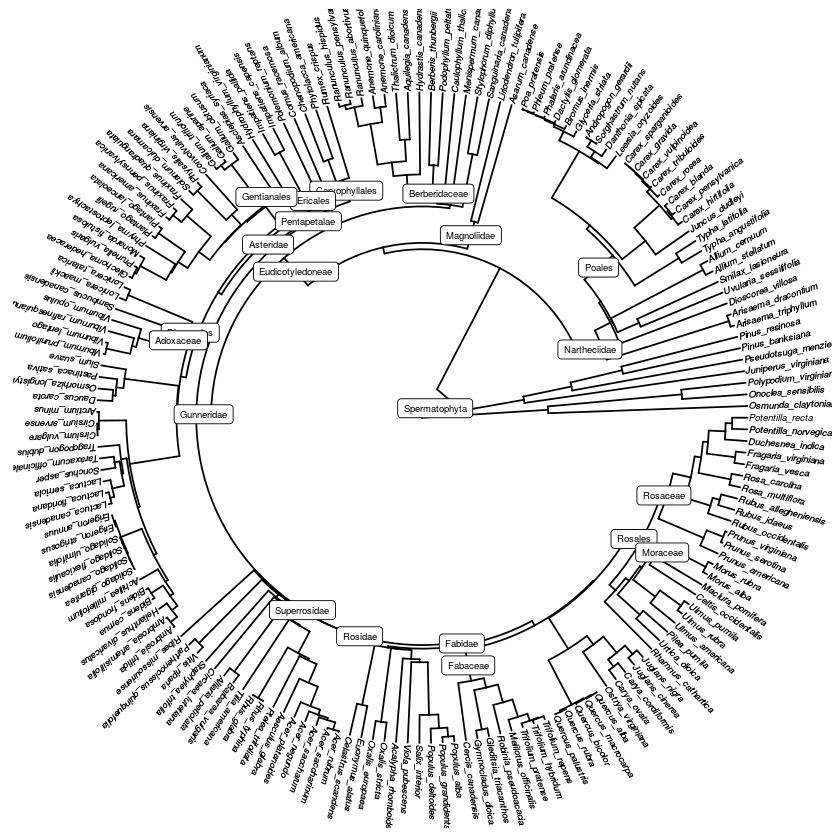

In [63]:
library(ggtree)
if(length(tr.pruned$node.label) == tr.pruned$Nnode) {
    tr.pruned$node.label <- c(rep(NA, length(tr.pruned$tip.label)), 
                          tr.pruned$node.label)
    tr.pruned$node.label[tr.pruned$node.label == ''] <- NA
    }
p <- ggtree(tr.pruned, layout = 'circular')
p <- p + geom_tiplab(fontface = 'italic', size = 2, aes(angle = angle))
p <- p + geom_label(aes(x = branch), label = tr.pruned$node.label, size = 2)
print(p)

There's lots more to do! But here's a start for us. With this, we'd be almost set to analyze a community or trait dataset.